In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(sec:linear_simple)=
# Simple Linear Model

Modeling starts with an outcome variable $ y $ and one or more
predictor variables $ x $.
When $ y $ is a numeric variable like height or income, we say that we're
doing *regression*.
When $ y $ is a categorical variable like
the presidential candidate on a ballet, we say that we're
doing *classification*.
We assume that $ x $ is numeric [^feat].

[^feat]: Later in this chapter
({numref}`Section %s <sec:linear_feature_eng>`) 
we'll see ways of working with categorical predictor variables.

When we use a simple linear model,
we assume that the outcome $ y $ depends linearly
on a given predictor $ x $ with some random measurement error $ \epsilon $:

$$
\begin{aligned}
y = \theta_0 + \theta_1 x + \epsilon
\end{aligned}
$$

The simple linear model $ f_{\theta}(x) $ doesn't try to model the measurement
error. Instead, it predicts $ y $ for a single value of $ x $:

$$
\begin{aligned}
f_{\theta}(x) = \theta_0 + \theta_1 x
\end{aligned}
$$


In the equations above, $ \theta_0 $ and $ \theta_1 $ are constants that
we call the *model parameters*.
It's custom to say that the column vector $ \theta = [ \theta_0, \theta_1 ] $.
So, $ \theta $ is a vector that contains all of the model parameters,
and $ \theta_1 $ is a scalar that represents a single model parameter.
The first steps in modeling are to pick $ x $ and $ y $, then 
figure out what $ \theta_0 $ and $ \theta_1 $ are.

:::{note}

We'll work with $ \epsilon $ more rigorously in future chapters.
For now, the important idea to remember is that the model depends on
$ x $. For example,
when $ \theta_1 $ is positive, bigger values of $ x $ make the
prediction $ f_{\theta}(x) $ bigger.

:::

The simple linear model is useful because $ x $ and $ y $ can be any two
variables of interest. In this chapter, we'll use linear models to understand
what factors contribute to economic opportunity in the US.

## Data: Where is the Land of Opportunity?

The US was nicknamed "the land of opportunity" because people believed that
even poor people in the US could end up wealthy---economists call this 
economic mobility. 
In a famous study, the economist Raj Chetty and his colleagues
did a large-scale data analysis on 
economic mobility in the US {cite}`chettyWhere2014`.
But Chetty had a hunch that some places in the US have much higher economic
mobility than others.
His analysis found this to be true.
Cities like San Jose, Washington DC, and Seattle have higher
mobility than places like Charlotte, Milwaukee, and Atlanta.
This means that overall, more people move from low income to high
income in San Jose compared to Charlotte.
Chetty also used linear models to find out that social and economic
factors like segregation, income inequality, and local school systems 
are related to economic mobility.
In this chapter, we'll use linear models to replicate parts of his analysis.

To do his analysis, Chetty used government tax records to get the incomes of
everyone born in the US between 1980-82.
He looked at each person's income in 2011-12 when they were about
30 years old, and compared it to their parents' income when they were born.
In total, his dataset had about 10 million people.
To define economic mobility, Chetty took the people who were born into the
25th income percentile and found the income percentile they ended up with
30 years later. He called this statistic the *absolute upward mobility* (AUM).
If a region's average AUM is 25, then people in the 25th percentile generally
stay in the 25th percentile---they stay where they are.
High AUM values mean that the region has high mobility.
People in these regions generally make more than their parents.
For reference, the US average AUM is about 41 at the time of this writing.
Chetty averaged together the AUMs for regions of the US called commuting zones
(CZ).
Commuting zones are defined by the economy of a region and are on the 
same scale as counties. 
While individual income records can't be publicly available because of privacy,
the AUMs for each commuting zone are publicly available.
Since Chetty also used commuting zone AUMs, we can replicate his analysis
using publicly available data.

So, our outcome variable $ y $ represents the AUM for a commuting zone.
There are many possible predictor variables in Chetty's data.
For our first simple linear model, we'll pick the predictor variable
$ x $ to be the
fraction of people who have a 15-minute or shorter commute to work.

## Predicting Upward Mobility using Commute Time

Let's take a look at the data.
We'll load Chetty's data into the `df` variable.

In [11]:
df = (
    pd.read_csv('data/mobility.csv')
    # filter out rows with NaN AUM values
    .query('not aum.isnull()', engine='python')
)
df

,cz,czname,stateabbrv,aum,...,cs_fam_wkidsinglemom,cs_divorced,cs_married,incgrowth0010
0,100.0,Johnson City,TN,38.39,...,0.19,0.11,0.60,-2.28e-03
1,200.0,Morristown,TN,37.78,...,0.19,0.12,0.61,-2.15e-03
2,301.0,Middlesborough,TN,39.05,...,0.21,0.11,0.59,-3.71e-03
...,...,...,...,...,...,...,...,...,...
738,39302.0,Bellingham,WA,44.12,...,0.19,0.10,0.54,-6.95e-03
739,39303.0,Port Angeles,WA,41.41,...,0.24,0.12,0.60,4.91e-05
740,39400.0,Seattle,WA,43.20,...,0.19,0.12,0.54,-1.55e-03


Each row in `df` represents one commuting zone.
The column `aum` has the average AUM metric for each commuting zone.
There are many columns in `df` since this dataframe also has the
covariates for each CZ.
For our simple linear model, we want the
`frac_traveltime_lt15` column which has the fraction of people
in each CZ that have a 15 minute or shorter commute time.
We'll plot `aum` against `frac_traveltime_lt15` to see the
relationship between the two variables.

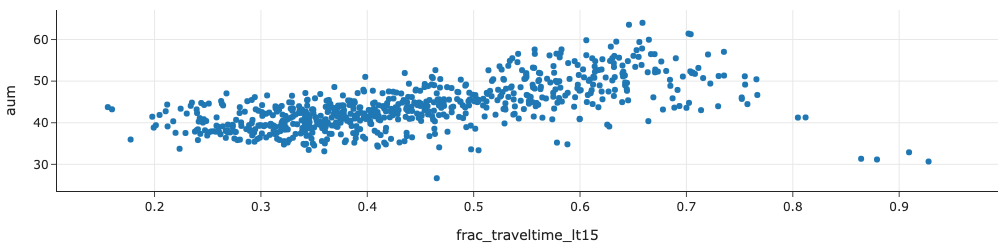

In [6]:
px.scatter(df, x='frac_traveltime_lt15', y='aum',
           width=350, height=250)

Our model is $ f_{\theta}(x) = \theta_0 + \theta_1 x $ where
$ x $ is the `frac_traveltime_lt15` for a commuting zone and
the predicted outcome $ y $ is the `aum`.
By looking at the scatter plot above, we can guess that $ \theta_1 $ should be
positive since `aum` is bigger for bigger values of `frac_traveltime_lt15`.
In the next section, we'll use loss minimization to find
$ \theta_0 $ and $ \theta_1 $ precisely.